In [1]:
import os
from pathlib import Path

import numpy as np
import cv2
import albumentations as albu
import albumentations.pytorch

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from models import EfficientNetEncoder, EncoderLocalFeatures

from utils import t2d, ImagesDataset, load_image

%matplotlib inline

In [2]:
DATA_DIR = "imagewoof2-320"

valid_transforms = albu.Compose([
    albu.Resize(224, 224),
    albu.Normalize(),
    albu.pytorch.ToTensorV2()
])

classes = sorted(set(os.listdir(os.path.join(DATA_DIR, "train"))))

class2index = {item: num for num, item in enumerate(classes)}

def _images_and_classes(folder):
    files, targets = [], []
    for file in folder.glob("*/*.JPEG"):
        image_folder = str(file).split("/")[-2]
        files.append(str(file))
        targets.append(class2index[image_folder])
    return files, targets

In [3]:
valid_dataset = ImagesDataset(
    *_images_and_classes(Path(DATA_DIR) / "val"), transforms=valid_transforms
)

In [4]:
encoder = EfficientNetEncoder("efficientnet-b1")
encoder.load_state_dict(
    torch.load("encoder.pth", map_location="cpu")["encoder_state_dict"]
)

model = EncoderLocalFeatures(encoder, 10)
model.eval()

for param in model.encoder.parameters():
    param.requires_grad = False


model.load_state_dict(
    torch.load("local_features.pth", map_location="cpu")["model_state_dict"]
)

Loaded pretrained weights for efficientnet-b1


<All keys matched successfully>

In [5]:
def show_attention_map(img_path):
    img = load_image(img_path)
    img_tensor = valid_transforms(image=img)["image"].unsqueeze(0)

    emb, rec, cls, attn_probs = model(img_tensor)

    attn_probs = attn_probs.squeeze(0).detach().permute(1, 2, 0).numpy()


    fig = plt.figure(figsize=(7, 7), frameon=False)
    extent = 0, 224, 0, 224

    img = cv2.resize(img, (224, 224))
    im1 = plt.imshow(img, extent=extent)

    heatmap = cv2.resize(attn_probs, (224, 224), fx=0, fy=0, interpolation=cv2.INTER_NEAREST)
    im2 = plt.imshow(heatmap, cmap=plt.cm.viridis, alpha=.4, interpolation='bilinear', extent=extent)
    plt.colorbar()

    plt.show()

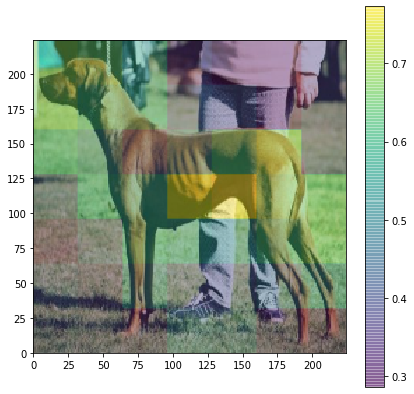

In [6]:
show_attention_map(valid_dataset.images[4])

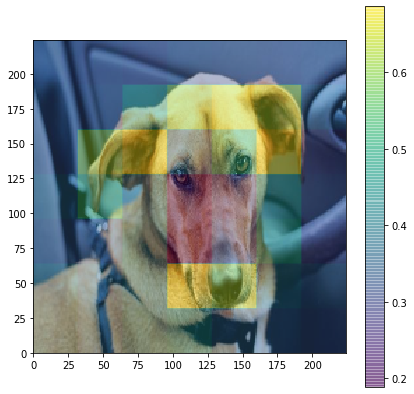

In [7]:
show_attention_map(valid_dataset.images[31])

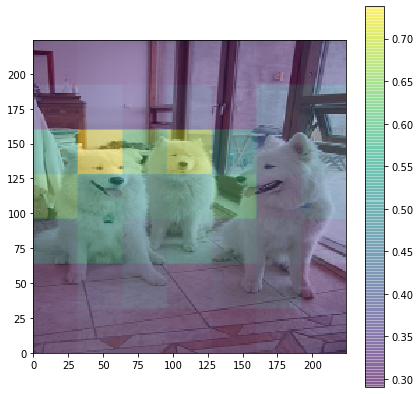

In [8]:
show_attention_map(valid_dataset.images[777])

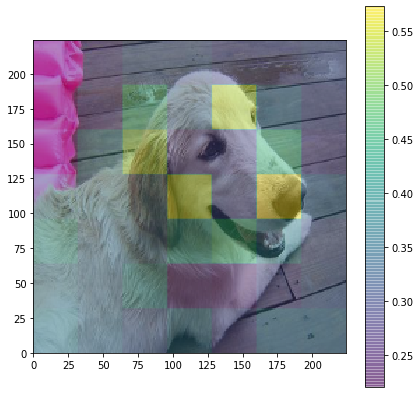

In [9]:
show_attention_map(valid_dataset.images[-123])